In [6]:
import math
import serial
import serial.tools.list_ports
from dataclasses import dataclass
from bitstring import BitArray

# list available ports
# ports = list(serial.tools.list_ports.comports())
# for p in ports:
#     print(p.device, p.description)

ser = serial.Serial('COM8', baudrate=2e6, timeout=2)  # timeout in seconds
print("Port opened:", ser.is_open)

response = b''
try:
    while True:
        response += ser.read_all()
except KeyboardInterrupt:
    pass
finally:
    ser.close()

print("Read", len(response), "bytes")

@dataclass
class Buffer:
    label: str
    length: int
    granularity: int
    iq: list[tuple[int, int]]

# [DBA,2028,4=....]
def parseBuffer(raw: bytes, x: int) -> tuple[Buffer, int]:
    x += 1  # skip '['

    label = ''
    while raw[x] != ord(','):
        label += chr(raw[x])
        x += 1
    x += 1

    length = ''
    while raw[x] != ord(','):
        length += chr(raw[x])
        x += 1
    length = int(length)
    x += 1

    granularity = ''
    while raw[x] != ord('='):
        granularity += chr(raw[x])
        x += 1
    granularity = int(granularity)
    x += 1

    nBytes = math.ceil((length * 2 * granularity) / 8)
    bits = BitArray(bytes=raw[x:x+nBytes])

    IQ = []
    for iq in bits.cut(granularity * 2):
        rescale = 1 << (16 - granularity)
        IQ.append( (iq[0:granularity].int * rescale, iq[granularity:granularity*2].int * rescale) )
    x += nBytes + 1

    return Buffer(
        label,
        length,
        granularity,
        IQ
    ), x

IQ = []
startSeq = b'[DB,2048,'
i = 0
n = 0
while True:
    i = response.find(startSeq, i)
    if i == -1:
        break
    n += 1
    buf, i = parseBuffer(response, i)
    IQ.extend(buf.iq)

print("Parsed", n, "buffers,", len(IQ), "IQ pairs total")


Port opened: True
Read 346492 bytes
Parsed 168 buffers, 344064 IQ pairs total


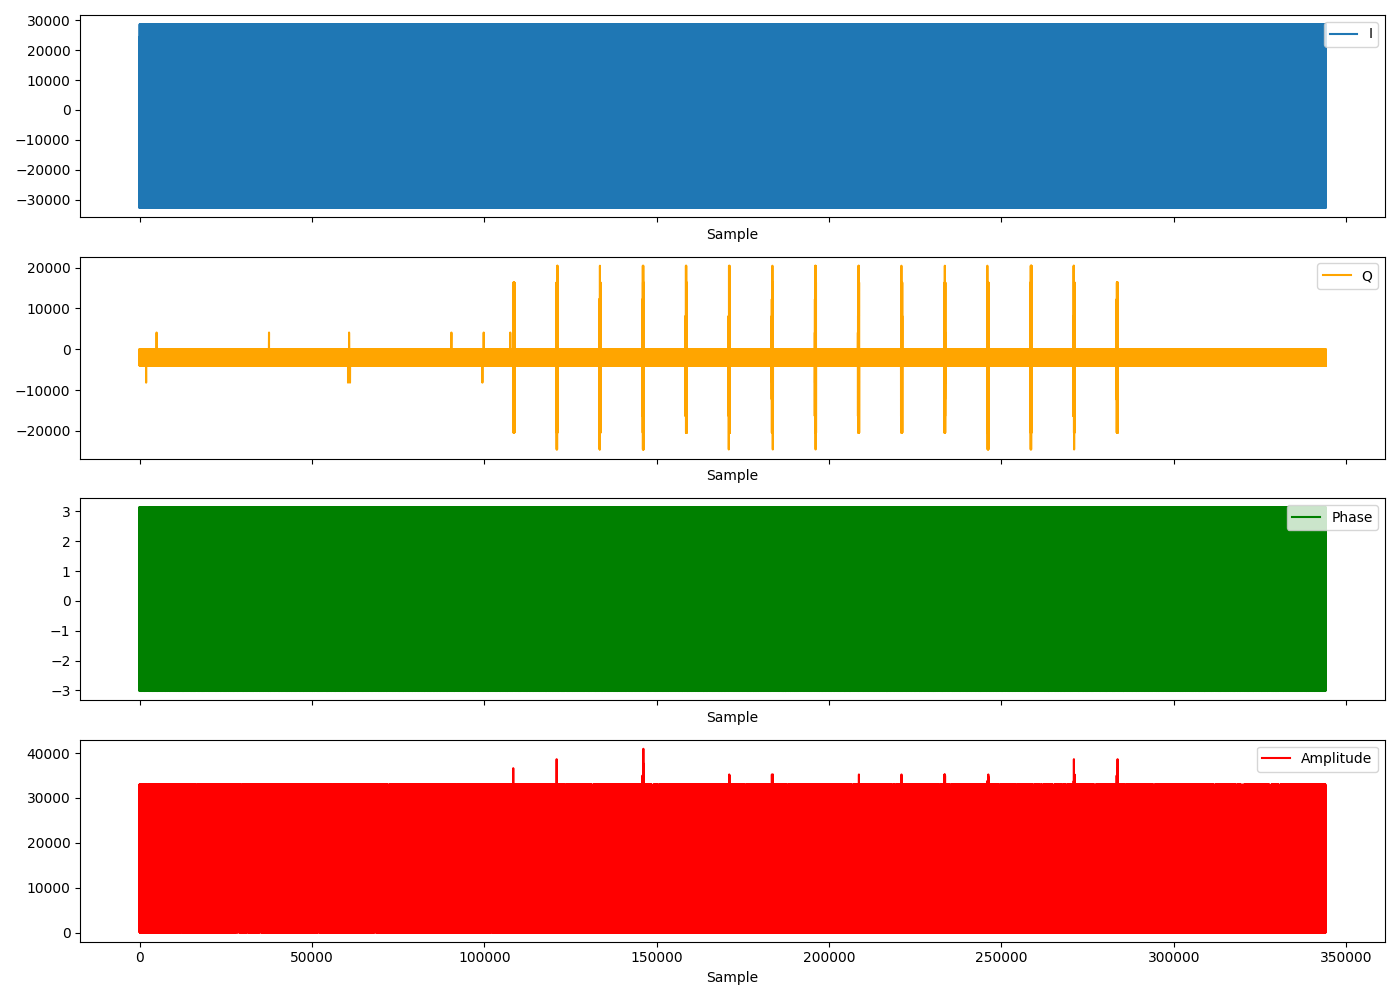

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
import math

I = [x[0] for x in IQ]
Q = [x[1] for x in IQ]
phase = [math.atan2(x[1], x[0]) for x in IQ]
A = [math.sqrt(x[0]**2 + x[1]**2) for x in IQ]

try:
    microSecondsPerSample = 1e6 / iqf
    time = [i * microSecondsPerSample for i in range(len(IQ))]
    timeLabel = 'Time (µs)'
except NameError:
    time = list(range(len(IQ)))
    timeLabel = 'nSample'

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(14, 10))
axs: list[plt.Axes]
(ax1, ax2, ax3, ax4) = axs
ax1.plot(time, I, label='I')
ax1.legend(loc='upper right')
ax2.plot(time, Q, label='Q', color='orange')
ax2.legend(loc='upper right')
ax3.plot(time, phase, label='Phase', color='green')
ax3.legend(loc='upper right')
ax4.plot(time, A, label='Amplitude', color='red')
ax4.legend(loc='upper right')

for ax in axs:
    # ax.axvline(time[len(DBA)+finish[1]], color='gray', linestyle='--')
    ax.set_xlabel(timeLabel)

plt.tight_layout()
plt.show()